# VC - Entrega Práctica 3
---
 - Luis Martín Pérez
- Andrea Santana López

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

### TAREA 1 - Detector de dinero en monedas

In [2]:
img = cv2.imread('Monedas.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Umbral fijo usado  200.0
Monedas encontradas: 8


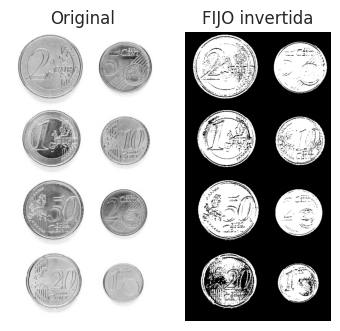

In [3]:
umbral = 200
th,img_th = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th)


plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th,cmap='gray')
plt.title('FIJO invertida')

contornos_externos, hierarchy = cv2.findContours(img_th,
    cv2.RETR_EXTERNAL ,
    cv2.CHAIN_APPROX_SIMPLE
)

coin_count = 0
for contorno in contornos_externos:
    area = cv2.contourArea(contorno)
    if area > 10:
        coin_count += 1

print(f"Monedas encontradas: {coin_count}")